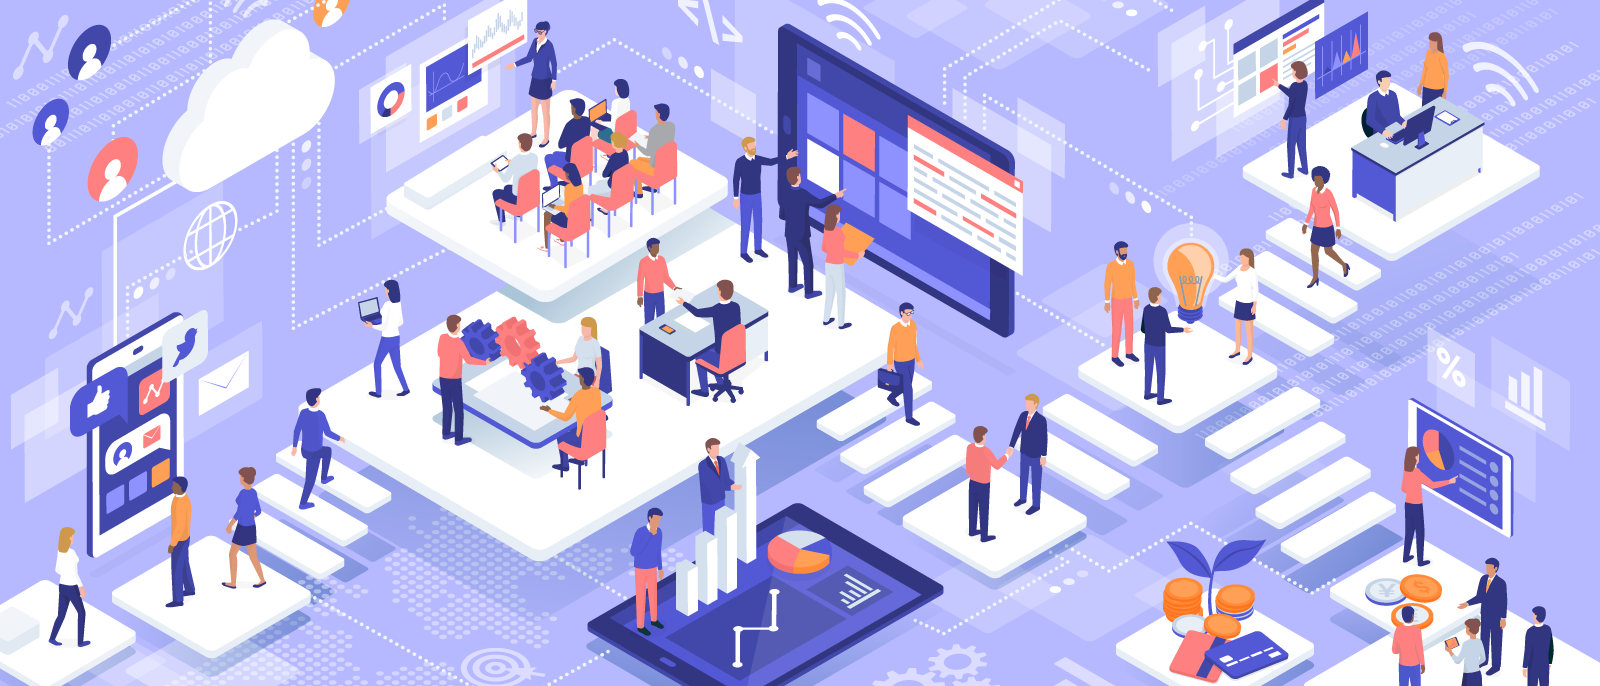

# Staff Planning for Insurance Company - Operations Research

An insurance company wants help in finding the optimal number of staff that they need for their insurance application approval process. In the industry, the number of staff is considered a continuous variable. This is also called a Full-Time Equivalent (FTE) of the staff.

The company operates in three states: A, B and C.

The company can either handle an application with the staff that they hire or outsource it to a vendor. Assume that there is no capacity limitation to outsourcing.

If they hire staff, he/she can handle 40 insurance applications per month when he/she works 100% of the workdays. However, there are days that he/she will be unavailable to process applications due to training, off days, etc.

States A and B have a regulatory restriction that the outsourced insurance applications cannot be more than 30% and 40% of the total number of applications for each month, respectively.

The objective is to optimise the total cost for the application approval process by distributing the right number of applications between the FTEs and the vendors while meeting the monthly demand for each state at the same time.

In [1]:
#Installing libraries
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc
!apt-get install -y -qq glpk-utils
!pip install -q openpyxl

Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 100799 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb ...
Unpacking coinor-libcgl1 (0.60.3+repack1-2) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unpack .../4-coinor-libcbc3_2.10.3+repack1-1build1_amd64.deb ...
Unpacking coinor-libcbc3 (2.10.3+repack1-1build1) ...
Sel

In [2]:
# Importing Libraries

from __future__ import division
from pyomo.environ import *
from pyomo.opt import SolverFactory

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Reading the data from Excel workbook

#Dataframe for the Staff information
StaffAvailability = pd.read_excel("../input/staffing-data/StaffingData.xlsx", sheet_name ='StaffAvailability')

#Dataframe for the Staffing Cost
cost = pd.read_excel("../input/staffing-data/StaffingData.xlsx", sheet_name ='Cost')

#Dataframe for the Service Rate
ServiceRate = pd.read_excel("../input/staffing-data/StaffingData.xlsx", sheet_name ='ServiceRate')

#Dataframe for the Demand related information
DemandData = pd.read_excel("../input/staffing-data/StaffingData.xlsx", sheet_name ='DemandData')


## Data pre-processing 

In [4]:
# Creating the required Python data structures for indexes and parameters

# Creating a Dictionary object for Demand
Demand = DemandData.set_index(['State','Month'])['Demand'].to_dict()

# Creating a Dictionary object for FTE_Salary
FTE_Salary = cost.set_index(['State','Month'])['MonthlySalary'].to_dict()

# Creating a Dictionary object for UnitOutSourceCost
UnitOutSourceCost = cost.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()

FTE_AppServRate = 40

StaffAvailability_StaffAvPer = StaffAvailability.set_index(['State','Month'])['StaffAvPer'].to_dict()

StaffAvailability_StaffAv_LB = StaffAvailability.set_index(['State','Month'])['LB'].to_dict()

StaffAvailability_StaffAv_UB = StaffAvailability.set_index(['State','Month'])['UB'].to_dict()

State = cost['State'].unique()

Month = cost['Month'].unique()

Decision Variable:

> ${FTE}_{S,M} \,\,\,\,\,\,\, \text{where} \ S \in State \ M \in Month $<br>

> ${O}_{S,M} \,\,\,\,\,\,\, \text{where} \ S \in State \ M \in Month $<br>


Objective Function:

> $\textrm{min} \sum \limits _{S,M} \text{FTE}_{S,M}* \text{FTE_Salary}_{S,M}$ $\text{+}$ $\text{O}_{S,M}* \text{O_Salary}_{S,M}$


Constraint:

>  $\text{total_demand}_{S,M}\ \text{==}\ \ \text{FTE}_{S,M}*40*\text{SA}_{S,M}+\text{O}_{S,M} \ \ \ \ \forall {S \in State} \ {M \in Month}$


>  $\text{O}_{S,M}\leq\text{total_demand}_{S,M}*0.30\ \ \ \ \forall {S \in State A}$

>  $\text{O}_{S,M}\leq\text{total_demand}_{S,M}*0.40\ \ \ \ \forall {S \in State B}$


In [5]:
# Creating a model instance
model = ConcreteModel()

In [6]:
# Defining Pyomo sets and Parameters
model.S = Set(initialize=State.tolist(),doc='States')
model.M = Set(initialize=Month.tolist(),doc='Months')
model.demand = Param(model.S,model.M,initialize = Demand,doc='Demand')
model.sa = Param(model.S,model.M,initialize = StaffAvailability_StaffAvPer,doc = 'StaffAvailability_StaffAvPercent')

In [7]:
# Decision variables
model.F = Var(model.S,model.M,doc='No. of FTE',domain = NonNegativeReals)
model.O = Var(model.S,model.M,doc='No of Outsource App',domain = NonNegativeIntegers)

In [8]:
# Constraints

# Creating Demand Constraint
def total_demand(m,S,M):
    return (m.F[S,M]*40*m.sa[S,M] + m.O[S,M] == m.demand[S,M])
            
model.total_demand = Constraint(model.S,model.M, rule=total_demand)

# creating Outsource Demand Constraints
model.outsource_demand = ConstraintList()
for M in model.M:
    for S in model.S:
        if S == 'A':
            model.outsource_demand.add(expr = model.O[S,M] <= 0.3*model.demand[S,M])
        elif S == 'B':
            model.outsource_demand.add(expr = model.O[S,M] <= 0.4*model.demand[S,M])

In [9]:
# Objective function
model.value = Objective(expr = sum(sum(model.F[S,M]*FTE_Salary[S,M] + model.O[S,M]*UnitOutSourceCost[S,M] for S in model.S) for M in model.M), sense= minimize)

In [10]:
# Invoking the solver

result = SolverFactory('glpk').solve(model, tee=True)
result.write()

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /tmp/tmpbr380beb.glpk.raw --wglp /tmp/tmp9m7ff_wr.glpk.glp --cpxlp
 /tmp/tmprlcu0zy2.pyomo.lp
Reading problem data from '/tmp/tmprlcu0zy2.pyomo.lp'...
61 rows, 73 columns, 97 non-zeros
36 integer variables, none of which are binary
469 lines were read
Writing problem data to '/tmp/tmp9m7ff_wr.glpk.glp'...
440 lines were written
GLPK Integer Optimizer, v4.65
61 rows, 73 columns, 97 non-zeros
36 integer variables, none of which are binary
Preprocessing...
Objective value =   1.796233645e+07
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.1 Mb (72516 bytes)
Writing MIP solution to '/tmp/tmpbr380beb.glpk.raw'...
143 lines were written
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# -------------------------------------------------

In [11]:
# Printing the value of the objective function
optimized_cost = round(model.value()/1000000,2)

print("\n\n Seems like the company has to spend around {}m$ in total for the application approval process." .format(optimized_cost))





 Seems like the company has to spend around 17.96m$ in total for the application approval process.


In [12]:
# Creating dataframe for the results

#Creating an empty list
Output_actual = []


for S in model.S:
    for M in model.M:
        
        #cost for the application approval process
        no_of_fte=model.F[S,M].value
        demand = model.demand[S,M]
        no_of_outsource_app = model.O[S,M].value
        no_of_FTE_processed_app = model.F[S,M].value*40*model.sa[S,M]
        cost = model.F[S,M].value*FTE_Salary[S,M] + model.O[S,M].value*UnitOutSourceCost[S,M]
        percent_outsourced_app = round((no_of_outsource_app/demand)*100,2)
        avg_cost_per_app = round(cost/demand,2)
        
        Output_actual.append([S,M, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, percent_outsourced_app,avg_cost_per_app])
        
Output_actual = pd.DataFrame(Output_actual, columns = ['State', 'Month', 'No. of FTE','Demand','No. of outsource application','No. of FTE Processed Application' , 'Estimated Cost', 'Percent outsourced Application', 'average cost per application'])

Output_actual[['Estimated Cost in mn $']] = Output_actual[['Estimated Cost']]/1000000
Output_actual['Demand'] = Output_actual['Demand'].astype(int)
Output_actual['No. of outsource application'] = Output_actual['No. of outsource application'].astype(int)
Output_actual['No. of FTE Processed Application'] = Output_actual['No. of FTE Processed Application'].astype(int)
Output_actual = Output_actual.round({"No. of FTE":1, "No. of outsource application":0, "Estimated Cost in mn $":1})

## Worst case analysis 

#### Optimal number of staff members

In [13]:
# Creating a model instance
model1 = ConcreteModel()

In [14]:
# Defining Pyomo sets and Parameters
model1.S = Set(initialize=State.tolist(),doc='States')
model1.M = Set(initialize=Month.tolist(),doc='Months')
model1.demand = Param(model1.S,model1.M,initialize = Demand,doc='Demand')
model1.sa = Param(model1.S,model1.M,initialize = StaffAvailability_StaffAv_LB,doc = 'StaffLowerBoundPercent')

In [15]:
# Decision variables
model1.F = Var(model1.S,model1.M,doc='No. of FTE',domain = NonNegativeReals)
model1.O = Var(model1.S,model1.M,doc='No of Outsource App',domain = NonNegativeIntegers)

In [16]:
# Constraints

# Demand Constraint
def total_demand(m, S, M):
    return (m.F[S,M] * 40 * m.sa[S,M] + m.O[S,M] == m.demand[S,M])


model1.total_demand = Constraint(model1.S, model1.M, rule=total_demand)

# Outsource Demand Constraints
model1.outsource_demand = ConstraintList()
for M in model1.M:
    for S in model1.S:
        if S == 'A':
            model1.outsource_demand.add(expr = model1.O[S,M] <= 0.3*model1.demand[S,M])
        elif S == 'B':
            model1.outsource_demand.add(expr = model1.O[S,M] <= 0.4*model1.demand[S,M])

In [17]:
# Objective function
model1.value = Objective(expr = sum(sum(model1.F[S,M]*FTE_Salary[S,M]+ model1.O[S,M]*UnitOutSourceCost[S,M] for S in model1.S) for M in model1.M),sense= minimize)

In [18]:
# Invoking the solver
result = SolverFactory('glpk').solve(model1)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.01799917221069336
# ----------------------------------------------------------
#   Solution Information
# ------------

In [19]:
# Printing the value of the objective function
optimized_cost_worst = round(model1.value()/1000000,2)

print("\n\n The company has to spend around {}m$ in total for the application approval process if the staffs are working with the minimum availability." .format(optimized_cost_worst))






 The company has to spend around 19.6m$ in total for the application approval process if the staffs are working with the minimum availability.


In [20]:
# Creating dataframe for the results
Output_worst = []

for S in model1.S:
    for M in model1.M:
       
        no_of_fte = model1.F[S,M].value
        demand = model1.demand[S,M]
        no_of_outsource_app = model1.O[S,M].value
        no_of_FTE_processed_app = model1.F[S,M].value*40*model1.sa[S,M]
        cost = model1.F[S,M].value*FTE_Salary[S,M] + model1.O[S,M].value*UnitOutSourceCost[S,M]

        percent_outsourced_app = round((no_of_outsource_app/demand)*100,1)
        avg_cost_per_app = round(cost/demand,1)

        Output_worst.append([S,M, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, percent_outsourced_app,avg_cost_per_app])
       
    
Output_worst = pd.DataFrame(Output_worst, columns = ['State', 'Month', 'No. of FTE worst','Demand','No. of outsource application worst',"No. of FTE Processed Application worst" , 'Estimated Cost worst', 'Percent outsourced Application worst', 'average cost per application worst'])

Output_worst['Estimated Cost in mn $ worst'] = Output_worst[['Estimated Cost worst']]/1000000
Output_worst['Demand'] = Output_worst['Demand'].astype(int)
Output_worst['No. of outsource application worst'] = Output_worst['No. of outsource application worst'].astype(int)
Output_worst['No. of FTE Processed Application worst'] = Output_worst['No. of FTE Processed Application worst'].astype(int)
Output_worst = Output_worst.round({"No. of FTE worst":1, "No. of outsource application worst":0, "Estimated Cost in mn $ worst":1})
#Output_worst[['Cost per application worst']] = Output_worst['Estimated Cost worst']/Output_worst['Demand']

total_outsourcing =  sum(Output_worst['No. of outsource application worst'])
total_cost = sum(Output_worst['Estimated Cost worst'])
optimal_staff_members = round(Output_worst['No. of FTE worst'].mean(),1)

total_demand =  sum(Output_worst['Demand'])
average_cost_per_appln = round(total_cost/total_demand,2)
percent_outsourced_app_total = round((total_outsourcing/total_demand)*100,1)
print("Total Outsourced Application: ", total_outsourcing)
print("Total Demand Application: ", total_demand)
print("Optimal Staff Members : ", optimal_staff_members)

Total Outsourced Application:  39808
Total Demand Application:  113294
Optimal Staff Members :  76.7


#### Percentage of outsourced applications 

In [21]:
print("Total Outsourced Application % is : ", percent_outsourced_app_total)

Total Outsourced Application % is :  35.1


#### Average cost per application

In [22]:
print("Average Cost per Application: ", average_cost_per_appln)

Average Cost per Application:  173.0


## Best Case Analysis 

#### Optimal number of staff members


In [23]:
# Creating a model instance
model2 = ConcreteModel()

In [24]:
# Define Pyomo sets and Parameters
model2.S = Set(initialize=State.tolist(),doc='States')
model2.M = Set(initialize=Month.tolist(),doc='Months')
model2.demand = Param(model2.S,model2.M,initialize = Demand,doc='Demand')
model2.sa = Param(model2.S,model2.M,initialize = StaffAvailability_StaffAv_UB,doc = 'StaffUpperBoundPercent')

In [25]:
# Decision variables
model2.F = Var(model2.S,model2.M,doc='No. of FTE',domain = NonNegativeReals)
model2.O = Var(model2.S,model2.M,doc='No of Outsource App',domain = NonNegativeIntegers)

In [26]:
# Constraints

# Demand Constraint

def total_demand(m, S, M):
    return (m.F[S, M] * 40 * m.sa[S, M] + m.O[S, M] == m.demand[S, M])


model2.total_demand = Constraint(model2.S, model2.M, rule=total_demand)

# Outsource Demand Constraints
model2.outsource_demand = ConstraintList()
for M in model2.M:
    for S in model2.S:
        if S == 'A':
            model2.outsource_demand.add(expr = model2.O[S,M] <= 0.3*model2.demand[S,M])
        elif S == 'B':
            model2.outsource_demand.add(expr = model2.O[S,M] <= 0.4*model2.demand[S,M])


In [27]:
# Objective function
model2.value = Objective(expr = sum(sum(model2.F[S,M]*FTE_Salary[S,M]+ model2.O[S,M]*UnitOutSourceCost[S,M] for S in model2.S) for M in model2.M),sense= minimize)

In [28]:
# Invoking the solver
result = SolverFactory('glpk').solve(model2)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.013847112655639648
# ----------------------------------------------------------
#   Solution Information
# -----------

In [29]:
# Printing the value of the objective function
optimized_cost_best = round(model2.value()/1000000,2)

print("\n\n The company has to spend around ${}m$ in total for the application approval process if the staffs are working with the maximum availability.".format(optimized_cost_best))




 The company has to spend around $16.53m$ in total for the application approval process if the staffs are working with the maximum availability.


In [30]:
# Creating dataframe for the results
Output_best = []

for S in model2.S:
    for M in model2.M:
        # cost for the application approval process
        no_of_fte = model2.F[S,M].value
        demand = model2.demand[S,M]
        no_of_outsource_app = model2.O[S,M].value
        no_of_FTE_processed_app = model2.F[S,M].value*40*model2.sa[S,M]
        cost = model2.F[S,M].value*FTE_Salary[S,M] + model2.O[S,M].value*UnitOutSourceCost[S,M]

        percent_outsourced_app = round((no_of_outsource_app/demand)*100,1)
        cost_per_app = round(cost/demand,1)

        Output_best.append([S,M, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, percent_outsourced_app,cost_per_app])

Output_best = pd.DataFrame(Output_best, columns = ['State', 'Month', 'No. of FTE best','Demand','No. of outsource application best',"No. of FTE Processed Application best" , 'Estimated Cost best', 'Percent outsourced Application best',  'cost per application best'])

Output_best[['Estimated Cost in mn $ best']] = Output_best[['Estimated Cost best']]/1000000
Output_best['Demand'] = Output_best['Demand'].astype(int)
Output_best['No. of outsource application best'] = Output_best['No. of outsource application best'].astype(int)
Output_best['No. of FTE Processed Application best'] = Output_best['No. of FTE Processed Application best'].astype(int)
Output_best = Output_best.round({"No. of FTE best":1, "No. of outsource application best":0, "Estimated Cost in mn $ best":1})
#Output_best[['Cost per application best']] = Output_best['Estimated Cost best']/Output_best['Demand']

total_outsourcing =  sum(Output_best['No. of outsource application best'])
total_cost = sum(Output_best['Estimated Cost best'])
optimal_staff_members = round(Output_best['No. of FTE best'].mean(),1)

total_demand =  sum(Output_best['Demand'])
average_cost_per_appln = round(total_cost/total_demand,2)
percent_outsourced_app_total = round((total_outsourcing/total_demand)*100,1)
print("Total Outsourced Application: ", total_outsourcing)
print("Total Demand Application: ", total_demand)
print("Optimal Staff Members : ", optimal_staff_members)

Total Outsourced Application:  4652
Total Demand Application:  113294
Optimal Staff Members :  92.9


#### Percentage of outsourced applications

In [31]:
print("Total Outsourced Application % is : ", percent_outsourced_app_total)

Total Outsourced Application % is :  4.1


#### Average cost per application

In [32]:
print("Average Cost per Application: ", average_cost_per_appln)

Average Cost per Application:  145.88


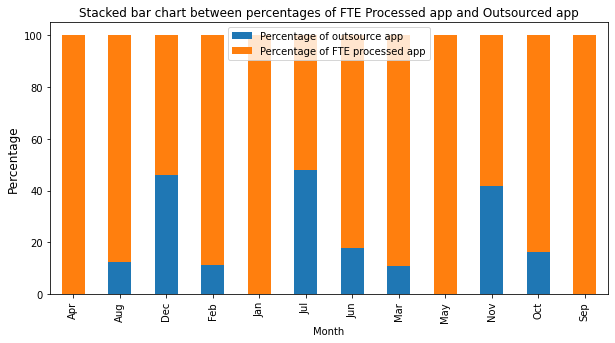

In [33]:
#Creating bar chart to show percentage of FTE and Outsourced application
df = Output_actual[['Month', 'Demand', 'No. of outsource application','No. of FTE Processed Application']].groupby(['Month']).sum()
df['Percentage of outsource app'] = df['No. of outsource application']/df['Demand']*100
df['Percentage of FTE processed app'] = df['No. of FTE Processed Application']/df['Demand']*100
ax = df[['Percentage of outsource app','Percentage of FTE processed app']].plot(kind='bar', stacked=True, figsize=(10,5))
ax.set_ylabel("Percentage", fontsize=12)
plt.title("Stacked bar chart between percentages of FTE Processed app and Outsourced app", fontsize=12)
plt.show()

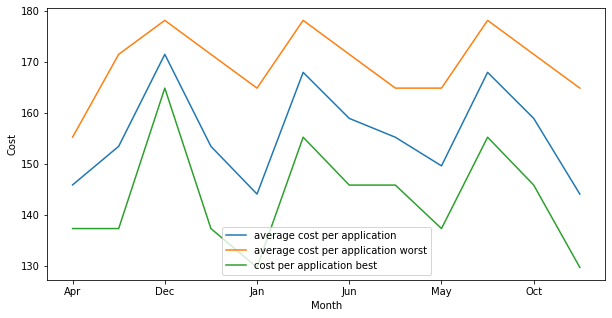

In [34]:
#Creating the chart to show cost per application in every case
df_new = pd.concat([Output_actual[['average cost per application','Month']], Output_worst['average cost per application worst'], Output_best['cost per application best']], axis=1)
df_new = df_new.groupby(['Month']).mean()
df_new.plot.line(figsize=[10,5])
plt.xlabel("Month")
plt.ylabel("Cost")
plt.show()
